# Advanced Neural Network Architectures for PBC Data Analysis

This notebook demonstrates the use of advanced neural network architectures in MultiStateNN for modeling Primary Biliary Cirrhosis (PBC) disease progression. We'll compare three different architectures:

1. **Standard MLP (Multilayer Perceptron)** - The baseline architecture using feedforward neural networks
2. **Recurrent Neural Networks (RNN/GRU)** - For capturing temporal dependencies in disease progression
3. **Attention-based Neural Networks** - Using self-attention mechanisms to model complex relationships

We'll analyze how these different architectures perform in terms of prediction accuracy, calibration, and their ability to capture the effect of covariates on disease progression.

## Setup

First, let's import the necessary packages and load the data. Make sure you've run the `scripts/download_data.py` script to download the dataset.

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting tools

# Import core MultiStateNN components
from multistate_nn import (
    fit, ModelConfig, TrainConfig,
    # Import visualization functions from the main package  
    plot_transition_heatmap, 
    plot_transition_graph, 
    plot_intensity_matrix,
    # Import utility functions from the main package
    setup_state_names_and_colors,
    create_patient_profile,
    create_covariate_profiles,
    analyze_covariate_effect,
    visualize_state_distribution
)

# Import simulation and analysis utilities
from multistate_nn.utils import (
    simulate_continuous_patient_trajectory, 
    calculate_cif, 
    plot_cif
)

# Import the visualization function from multistate_nn.utils.example_utils
from multistate_nn.utils.example_utils import visualize_state_distribution_over_time

# Import architecture-specific modules
from multistate_nn.architectures import (
    create_intensity_network,
    MLPIntensityNetwork,
    RecurrentIntensityNetwork,
    AttentionIntensityNetwork
)

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# Load the PBC dataset
try:
    pbc = pd.read_csv("../data/pbc.csv")
    print(f"Dataset loaded successfully with {len(pbc)} rows")
except FileNotFoundError:
    print("Dataset not found. Please run scripts/download_data.py first.")
    
# Show the first few rows
pbc.head()

Dataset loaded successfully with 418 rows


,id,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
0,1,400,2,1,58.765229,2,1,1,1,1.0,14.5,261,2.60,156,1718.0,137.95,172,190,12.2,4
1,2,4500,0,1,56.446270,2,0,1,1,0.0,1.1,302,4.14,54,7394.8,113.52,88,221,10.6,3
2,3,1012,2,1,70.072553,1,0,0,0,0.5,1.4,176,3.48,210,516.0,96.10,55,151,12.0,4
3,4,1925,2,1,54.740589,2,0,1,1,0.5,1.8,244,2.54,64,6121.8,60.63,92,183,10.3,4
4,5,1504,1,2,38.105407,2,0,1,1,0.0,3.4,279,3.53,143,671.0,113.15,72,136,10.9,3


In [3]:
# Understanding the PBC data structure:
# - status: 0=censored, 1=transplant, 2=dead
# - stage: 1-4, histologic stage of disease (1=best, 4=worst)

# We'll define our states as:
# 0: Stage 1 (early PBC)
# 1: Stage 2 (moderate PBC)
# 2: Stage 3 (advanced PBC)
# 3: Stage 4 (cirrhosis)
# 4: Liver transplant
# 5: Death

# Create a robust mapping function to convert stage to state
def stage_to_state(row):
    if row['status'] == 2:  # Death
        return 5
    elif row['status'] == 1:  # Transplant
        return 4
    else:  # Stage-based state
        try:
            # Make sure stage is a valid integer between 1-4
            stage = int(row['stage'])
            # Handle any out-of-range values
            if stage < 1:
                stage = 1
            elif stage > 4:
                stage = 4
            return stage - 1  # Convert stage 1-4 to state 0-3
        except (ValueError, TypeError):
            # If conversion fails, default to median stage
            return 2  # Default to Stage 3 (most common)

# Add state column to the PBC dataset
print("Adding 'state' column to PBC dataset...")
pbc['state'] = pbc.apply(stage_to_state, axis=1)

# Show distribution of states
print("State distribution:")
print(pbc['state'].value_counts().sort_index())

Adding 'state' column to PBC dataset...
State distribution:
state
0     21
1     64
2     97
3     50
4     25
5    161
Name: count, dtype: int64


In [4]:
# Create continuous-time transition dataset
# For continuous-time models, we need time_start and time_end instead of time and time_diff
print("Creating continuous-time transition dataset...")

# Check that the required columns exist in the PBC dataset
required_cols = ['id', 'time', 'status', 'trt', 'state']
missing_cols = [col for col in required_cols if col not in pbc.columns]
if missing_cols:
    print(f"Error: Missing required columns: {missing_cols}")
    print("Available columns:")
    print(pbc.columns.tolist())
    raise KeyError(f"Missing required columns: {missing_cols}")

transitions = []

# Define allowed transitions based on disease progression
# We'll allow progression to any worse state
for _, row in pbc.iterrows():
    patient_id = row['id']
    current_state = int(row['state'])
    time_observed = row['time'] / 365.0  # Convert to years
    
    # For continuous-time models, we need time intervals
    time_start = 0.0
    time_end = time_observed
    
    # Select relevant covariates (excluding id, time, status, trt, and derived state)
    covariates = row.drop(['id', 'time', 'status', 'trt', 'state']).to_dict()
    
    # Create transitions to all possible future states
    for next_state in range(current_state + 1, 6):  # Can progress to any worse state
        # Add transition record with time intervals
        transition_record = {
            'patient': patient_id,
            'time_start': time_start,
            'time_end': time_end,
            'from_state': current_state,
            'to_state': next_state,
            **covariates
        }
        transitions.append(transition_record)

# Create transitions DataFrame
transitions_df = pd.DataFrame(transitions)
print(f"Created {len(transitions_df)} transition records")

# Display the first few rows and the columns
print("\nFirst few rows of transitions_df:")
display(transitions_df.head())
print("\nColumns in transitions_df:")
print(transitions_df.columns.tolist())

Creating continuous-time transition dataset...
Created 777 transition records

First few rows of transitions_df:


,patient,time_start,time_end,from_state,to_state,age,sex,ascites,hepato,spiders,...,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
0,2.0,0.0,12.328767,2,3,56.446270,2.0,0.0,1.0,1.0,...,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
1,2.0,0.0,12.328767,2,4,56.446270,2.0,0.0,1.0,1.0,...,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,2.0,0.0,12.328767,2,5,56.446270,2.0,0.0,1.0,1.0,...,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,5.0,0.0,4.120548,4,5,38.105407,2.0,0.0,1.0,1.0,...,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
4,7.0,0.0,5.019178,2,3,55.534565,2.0,0.0,1.0,0.0,...,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0



Columns in transitions_df:
['patient', 'time_start', 'time_end', 'from_state', 'to_state', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'edema', 'bili', 'chol', 'albumin', 'copper', 'alk.phos', 'ast', 'trig', 'platelet', 'protime', 'stage']


In [5]:
# Check for missing values
print("Missing values per column:")
print(pbc.isnull().sum())

# Check for invalid values (like -2147483648)
print("\nChecking for implausible values in stage column:")
print(pbc['stage'].value_counts().sort_index().head())
print("\nChecking for implausible values in platelet column:")
print(pbc['platelet'].value_counts().sort_index().head())

Missing values per column:
id            0
time          0
status        0
trt           0
age           0
sex           0
ascites       0
hepato        0
spiders       0
edema         0
bili          0
chol          0
albumin       0
copper        0
alk.phos    106
ast         106
trig          0
platelet      0
protime       2
stage         0
state         0
dtype: int64

Checking for implausible values in stage column:
stage
-2147483648      6
 1              21
 2              92
 3             155
 4             144
Name: count, dtype: int64

Checking for implausible values in platelet column:
platelet
-2147483648    11
 62             1
 70             1
 71             1
 76             1
Name: count, dtype: int64


In [6]:
# Check that transitions_df was created correctly and inspect its structure
print("Verifying transitions_df structure...")

# Check if we have the expected columns
expected_columns = ['patient', 'time_start', 'time_end', 'from_state', 'to_state']
missing_columns = [col for col in expected_columns if col not in transitions_df.columns]

if missing_columns:
    print(f"Warning: Missing expected columns: {missing_columns}")
    print("Actual columns in transitions_df:")
    print(transitions_df.columns.tolist())
    
    # If any expected columns are missing, we need to verify the transition creation process
    if 'patient' not in transitions_df.columns:
        print("\nColumn 'patient' is missing. Checking for alternate column names...")
        # Check for similar columns that might serve the same purpose
        possible_alternatives = [col for col in transitions_df.columns if 'patient' in col.lower() or 'id' in col.lower()]
        if possible_alternatives:
            print(f"Possible alternatives: {possible_alternatives}")
    
    # Similarly check for other missing columns
    # This helps diagnose which step went wrong
else:
    print("All expected columns are present in transitions_df.")
    
# Display basic stats about the transitions
print(f"\nNumber of unique patients: {transitions_df['patient'].nunique()}")
print(f"Transition time range: {transitions_df['time_end'].min()} to {transitions_df['time_end'].max()} years")
print(f"From-state distribution:")
print(transitions_df['from_state'].value_counts().sort_index())
print(f"\nTo-state distribution:")
print(transitions_df['to_state'].value_counts().sort_index())

Verifying transitions_df structure...
All expected columns are present in transitions_df.

Number of unique patients: 257
Transition time range: 1.4602739726027398 to 13.136986301369863 years
From-state distribution:
from_state
0    105
1    256
2    291
3    100
4     25
Name: count, dtype: int64

To-state distribution:
to_state
1     21
2     85
3    182
4    232
5    257
Name: count, dtype: int64


In [7]:
# Before proceeding with feature selection, let's check what columns are in transitions_df
print("Columns in transitions_df:")
print(transitions_df.columns.tolist())

# Select most important clinical features based on domain knowledge
selected_features = [
    'age',           # Age is a key factor in disease progression
    'sex',           # Gender (women are more affected)
    'bili',          # Bilirubin - key liver function test
    'albumin',       # Albumin - important for liver function
    'protime',       # Prothrombin time - measures clotting
    'ascites',       # Presence of fluid in the abdomen
    'hepato',        # Hepatomegaly (enlarged liver)
    'edema'          # Edema (swelling)
    # Note: time_diff is not needed in continuous-time models as it's handled by time_start and time_end
]

# Check if all selected features are available
missing_features = [feat for feat in selected_features if feat not in transitions_df.columns]
if missing_features:
    print(f"Warning: Missing selected features: {missing_features}")
    selected_features = [feat for feat in selected_features if feat not in missing_features]

# Check for required columns for MultiStateNN
required_columns = ['patient', 'time_start', 'time_end', 'from_state', 'to_state']
for col in required_columns:
    if col not in transitions_df.columns:
        print(f"Error: Required column '{col}' not found in transitions_df")

# Get only needed columns, replacing any remaining missing values with median
model_data = transitions_df[required_columns + selected_features]
model_data = model_data.fillna(model_data.median())

# Scale numeric features (except categorical variables and time-related columns)
numeric_features = [feat for feat in selected_features 
                    if feat not in ['sex', 'ascites', 'hepato', 'patient', 'time_start', 'time_end', 'from_state', 'to_state']]

# Initialize scaler
scaler = StandardScaler()

# Scale numeric features
model_data[numeric_features] = scaler.fit_transform(model_data[numeric_features])

print("Features after scaling:")
model_data[numeric_features].describe().round(2)

# Verify transitions in our data match the state transition structure
transition_counts = model_data.groupby(['from_state', 'to_state']).size().reset_index(name='count')
print("\nObserved transitions:")
print(transition_counts)

Columns in transitions_df:
['patient', 'time_start', 'time_end', 'from_state', 'to_state', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'edema', 'bili', 'chol', 'albumin', 'copper', 'alk.phos', 'ast', 'trig', 'platelet', 'protime', 'stage']
Features after scaling:

Observed transitions:
    from_state  to_state  count
0            0         1     21
1            0         2     21
2            0         3     21
3            0         4     21
4            0         5     21
5            1         2     64
6            1         3     64
7            1         4     64
8            1         5     64
9            2         3     97
10           2         4     97
11           2         5     97
12           3         4     50
13           3         5     50
14           4         5     25


Defining state transition structure...
Number of states defined: 6


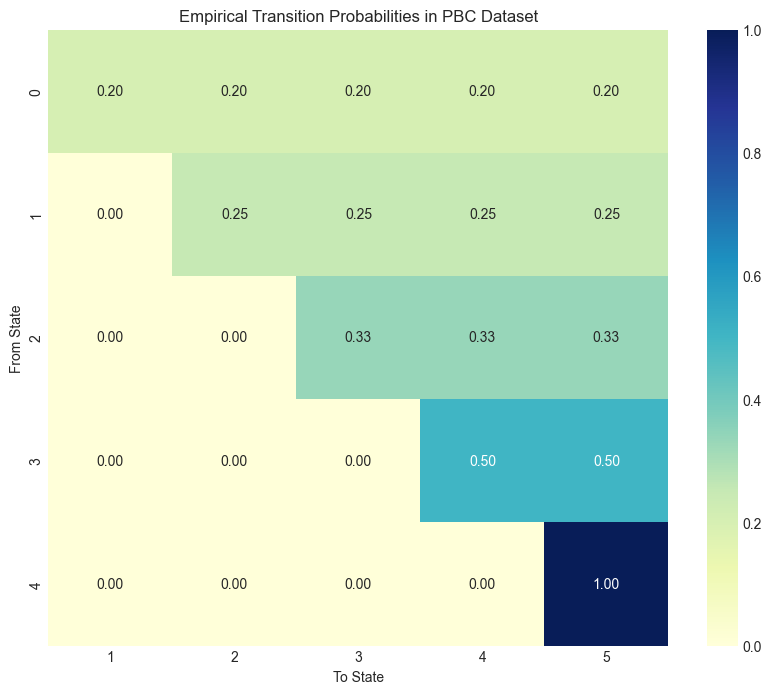

In [8]:
# Define state transition structure based on disease progression
print("Defining state transition structure...")

# States:
# 0: Stage 1 (early PBC) - can progress to any worse stage, transplant, or death
# 1: Stage 2 (moderate PBC) - can progress to any worse stage, transplant, or death
# 2: Stage 3 (advanced PBC) - can progress to stage 4, transplant, or death
# 3: Stage 4 (cirrhosis) - can progress to transplant or death
# 4: Liver transplant - can progress to death
# 5: Death - absorbing state

state_transitions = {
    0: [1, 2, 3, 4, 5],  # Stage 1 -> any worse stage, transplant, or death
    1: [2, 3, 4, 5],     # Stage 2 -> any worse stage, transplant, or death
    2: [3, 4, 5],        # Stage 3 -> stage 4, transplant, or death
    3: [4, 5],           # Stage 4 -> transplant or death
    4: [5],              # Transplant -> death
    5: []                # Death - absorbing state
}

# Define state names and colors for better visualization
state_names = ['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Transplant', 'Death']
state_colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#000000']

# Get the number of states from the state_transitions dictionary
num_states = len(state_transitions)
print(f"Number of states defined: {num_states}")

# Use the utility function to set up state names and colors
state_name_dict, state_color_dict = setup_state_names_and_colors(num_states, state_names, state_colors)

# Visualize the transition matrix
cross_tab = pd.crosstab(
    model_data['from_state'], 
    model_data['to_state'],
    normalize='index'
)

# Plot empirical transition probabilities
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Empirical Transition Probabilities in PBC Dataset')
plt.xlabel('To State')
plt.ylabel('From State')
plt.show()

In [9]:
# Split data into train and test sets (70% train, 30% test)
print("Splitting data into train and test sets...")

# We'll use this to evaluate performance of different architectures
train_data, test_data = train_test_split(
    model_data, 
    test_size=0.3, 
    random_state=42, 
    stratify=model_data['from_state']  # Stratify by from_state to preserve distribution
)

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

# Verify that the number of states is still defined
print(f"Number of states before model training: {num_states}")

Splitting data into train and test sets...
Training set size: 543
Test set size: 234
Number of states before model training: 6


In [10]:
# Make sure we have the correct number of states
# This should be 6 (Stage 1, Stage 2, Stage 3, Stage 4, Transplant, Death)
num_states = len(state_transitions)
print(f"Number of states: {num_states}")

# Define model parameters for all architectures
input_dim = len(selected_features)
print(f"Input dimension: {input_dim} (number of features)")

# For quick demonstration, we'll use a small number of epochs
# In practice, you may want to use more epochs for better convergence
# We'll define basic train config here and modify it for each architecture
base_train_config = TrainConfig(
    epochs=10,  # Reduced for demonstration
    batch_size=32,
    learning_rate=0.01,
    ode_solver="dopri5",  # Adaptive step-size solver for higher accuracy
    # Define solver options properly
    ode_solver_options={
        "rtol": 1e-3,  # Relative tolerance
        "atol": 1e-6   # Absolute tolerance
    }
)

Number of states: 6
Input dimension: 8 (number of features)


In [11]:
# 1. Train MLP Model
print("Training MLP model...")
mlp_config = ModelConfig(
    input_dim=input_dim,
    hidden_dims=[64, 32],  # Two hidden layers
    num_states=num_states,
    state_transitions=state_transitions,
    model_type="continuous"  # Specify continuous-time model
)

# Create a copy of the base train config and add MLP-specific options
mlp_train_config = TrainConfig(
    epochs=base_train_config.epochs,
    batch_size=base_train_config.batch_size,
    learning_rate=base_train_config.learning_rate,
    ode_solver=base_train_config.ode_solver,
    ode_solver_options=base_train_config.ode_solver_options,
    # Add architecture-specific parameters
    architecture_type="mlp",  # Specify MLP architecture
    architecture_options={
        "hidden_dims": [64, 32],
        "use_layernorm": True
    }
)

mlp_model = fit(
    df=train_data,
    covariates=selected_features,
    model_config=mlp_config,
    train_config=mlp_train_config,
    time_start_col='time_start',
    time_end_col='time_end'
)

print("MLP model training complete!")

Training MLP model...


Training continuous-time model:   0%|          | 0/10 [00:00<?, ?it/s]

MLP model training complete!


In [12]:
# 2. Train Recurrent Neural Network Model
print("Training RNN model...")
rnn_config = ModelConfig(
    input_dim=input_dim,
    hidden_dims=[64],  # Single hidden layer (the RNN will handle the rest)
    num_states=num_states,
    state_transitions=state_transitions,
    model_type="continuous"  # Specify continuous-time model
)

# Create a copy of the base train config and add RNN-specific options
rnn_train_config = TrainConfig(
    epochs=base_train_config.epochs,
    batch_size=base_train_config.batch_size,
    learning_rate=base_train_config.learning_rate,
    ode_solver=base_train_config.ode_solver,
    ode_solver_options=base_train_config.ode_solver_options,
    # Add architecture-specific parameters
    architecture_type="recurrent",  # Specify recurrent architecture
    architecture_options={
        "hidden_dim": 64,  # Dimension of hidden state
        "cell_type": "gru",  # Use GRU cells (alternative: "lstm")
        "num_layers": 1  # Number of recurrent layers
    }
)

rnn_model = fit(
    df=train_data,
    covariates=selected_features,
    model_config=rnn_config,
    train_config=rnn_train_config,
    time_start_col='time_start',
    time_end_col='time_end'
)

print("RNN model training complete!")

Training RNN model...


Training continuous-time model:   0%|          | 0/10 [00:00<?, ?it/s]

RNN model training complete!


In [13]:
# 3. Train Attention-based Model
print("Training Attention-based model...")
att_config = ModelConfig(
    input_dim=input_dim,
    hidden_dims=[64],  # Single hidden layer for initial projection
    num_states=num_states,
    state_transitions=state_transitions,
    model_type="continuous"  # Specify continuous-time model
)

# Create a copy of the base train config and add Attention-specific options
att_train_config = TrainConfig(
    epochs=base_train_config.epochs,
    batch_size=base_train_config.batch_size,
    learning_rate=base_train_config.learning_rate,
    ode_solver=base_train_config.ode_solver,
    ode_solver_options=base_train_config.ode_solver_options,
    # Add architecture-specific parameters
    architecture_type="attention",  # Specify attention architecture
    architecture_options={
        "hidden_dim": 64,  # Hidden dimension
        "num_heads": 4,  # Number of attention heads
        "num_layers": 2,  # Number of transformer layers
        "dropout": 0.1  # Dropout rate for regularization
    }
)

att_model = fit(
    df=train_data,
    covariates=selected_features,
    model_config=att_config,
    train_config=att_train_config,
    time_start_col='time_start',
    time_end_col='time_end'
)

print("Attention-based model training complete!")

Training Attention-based model...


Training continuous-time model:   0%|          | 0/10 [00:00<?, ?it/s]

Attention-based model training complete!


## Model Evaluation

Now let's evaluate the models on the test set to see how they perform.

In [14]:
# Helper function to evaluate models on test data
def evaluate_model(model, test_data, time_interval=1.0, from_state=0):
    """
    Evaluate model performance on test data.
    
    Parameters:
    - model: Trained MultiStateNN model
    - test_data: DataFrame with test data
    - time_interval: Time interval for prediction (in years)
    - from_state: Starting state for predictions
    
    Returns:
    - Dictionary with evaluation metrics
    """
    # Filter test data for the specified from_state
    test_subset = test_data[test_data['from_state'] == from_state]
    
    if len(test_subset) == 0:
        print(f"No test data found for from_state={from_state}")
        return None
    
    # Prepare input features
    X_test = torch.tensor(test_subset[selected_features].values, dtype=torch.float32)
    
    # Get model predictions
    preds = model.predict_proba(
        X_test, 
        time_start=0.0, 
        time_end=time_interval, 
        from_state=from_state
    ).detach().numpy()
    
    # Get actual next states
    next_states = test_subset['to_state'].values
    
    # Prepare metrics
    metrics = {}
    
    # Calculate accuracy (how often the most likely state is the correct one)
    predicted_states = np.argmax(preds, axis=1)
    accuracy = np.mean(predicted_states == next_states)
    metrics['accuracy'] = accuracy
    
    # Calculate Brier score (for calibration)
    # We'll convert next_states to one-hot encoding
    y_true = np.zeros_like(preds)
    for i, state in enumerate(next_states):
        y_true[i, state] = 1
    
    brier_score = np.mean(np.sum((preds - y_true) ** 2, axis=1)) / 2  # Divided by 2 to get range [0,1]
    metrics['brier_score'] = brier_score
    
    # Calculate log-likelihood
    eps = 1e-15  # Small constant to avoid log(0)
    log_probs = [np.log(max(preds[i, next_states[i]], eps)) for i in range(len(next_states))]
    log_likelihood = np.mean(log_probs)
    metrics['log_likelihood'] = log_likelihood
    
    return metrics

In [15]:
# Evaluate models on test data
# We'll evaluate at multiple time horizons to see how prediction quality changes
time_horizons = [0.5, 1.0, 2.0, 5.0]  # 6 months, 1 year, 2 years, 5 years
from_states = [0, 1, 2]  # We'll evaluate from Stage 1, 2, and 3

# Store results for each model, time horizon, and from_state
results = []

models = {
    'MLP': mlp_model,
    'RNN': rnn_model,
    'Attention': att_model
}

for model_name, model in models.items():
    for time_horizon in time_horizons:
        for from_state in from_states:
            # Evaluate model
            metrics = evaluate_model(model, test_data, time_interval=time_horizon, from_state=from_state)
            
            if metrics is not None:
                # Store results
                results.append({
                    'model': model_name,
                    'time_horizon': time_horizon,
                    'from_state': from_state,
                    'accuracy': metrics['accuracy'],
                    'brier_score': metrics['brier_score'],
                    'log_likelihood': metrics['log_likelihood']
                })

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)
results_df.head()

,model,time_horizon,from_state,accuracy,brier_score,log_likelihood
0,MLP,0.5,0,0.0000,0.716038,-4.058913
1,MLP,0.5,1,0.0000,0.808159,-4.125951
2,MLP,0.5,2,0.0000,0.765917,-3.386304
3,MLP,1.0,0,0.0625,0.604706,-3.250510
4,MLP,1.0,1,0.0000,0.690930,-3.258481


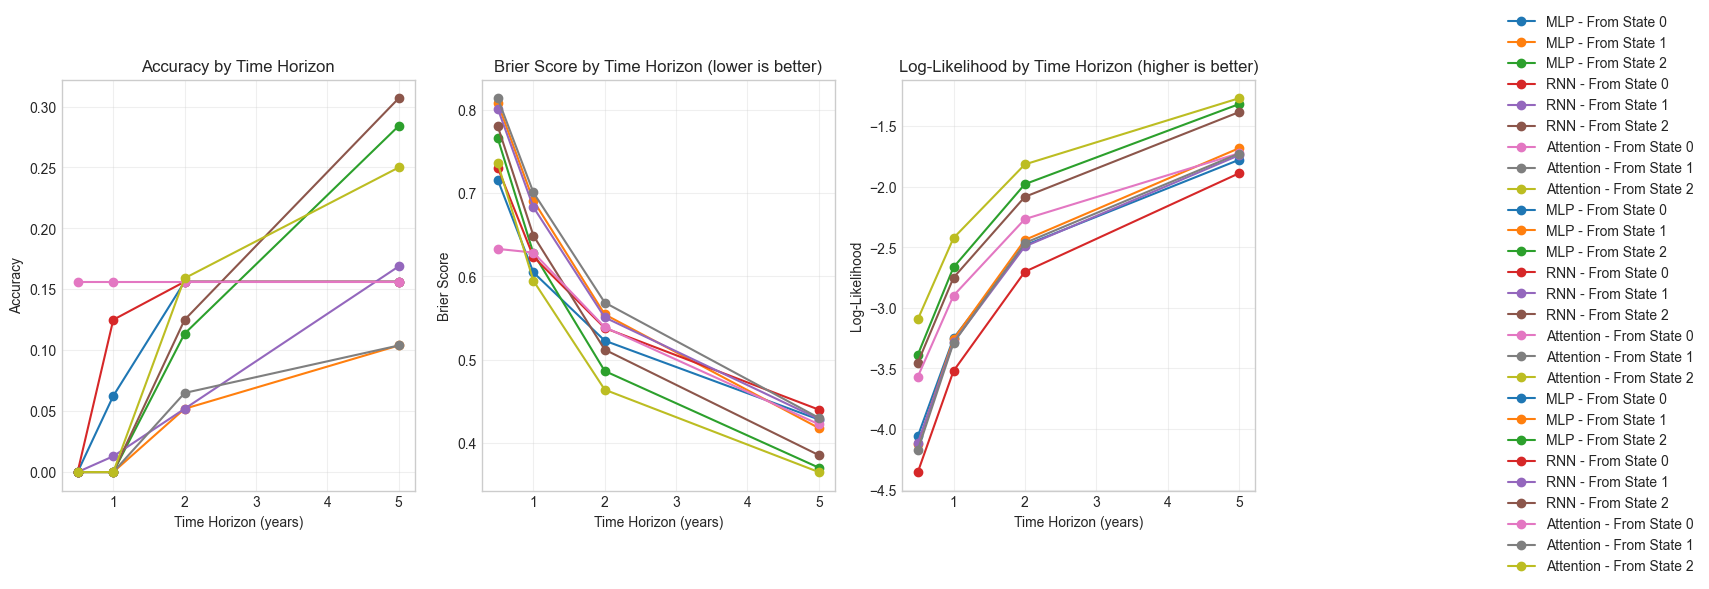

In [16]:
# Visualize model performance across different time horizons
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
for model_name in models.keys():
    model_results = results_df[results_df['model'] == model_name]
    for from_state in from_states:
        state_results = model_results[model_results['from_state'] == from_state]
        plt.plot(
            state_results['time_horizon'], 
            state_results['accuracy'], 
            marker='o',
            label=f"{model_name} - From State {from_state}"
        )
plt.title('Accuracy by Time Horizon')
plt.xlabel('Time Horizon (years)')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

# Plot Brier score (lower is better)
plt.subplot(1, 3, 2)
for model_name in models.keys():
    model_results = results_df[results_df['model'] == model_name]
    for from_state in from_states:
        state_results = model_results[model_results['from_state'] == from_state]
        plt.plot(
            state_results['time_horizon'], 
            state_results['brier_score'], 
            marker='o',
            label=f"{model_name} - From State {from_state}"
        )
plt.title('Brier Score by Time Horizon (lower is better)')
plt.xlabel('Time Horizon (years)')
plt.ylabel('Brier Score')
plt.grid(True, alpha=0.3)

# Plot log-likelihood (higher is better)
plt.subplot(1, 3, 3)
for model_name in models.keys():
    model_results = results_df[results_df['model'] == model_name]
    for from_state in from_states:
        state_results = model_results[model_results['from_state'] == from_state]
        plt.plot(
            state_results['time_horizon'], 
            state_results['log_likelihood'], 
            marker='o',
            label=f"{model_name} - From State {from_state}"
        )
plt.title('Log-Likelihood by Time Horizon (higher is better)')
plt.xlabel('Time Horizon (years)')
plt.ylabel('Log-Likelihood')
plt.grid(True, alpha=0.3)

# Add legend to the right of the plot
plt.figlegend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

## Compare Model Predictions

Let's analyze how the different models predict transition probabilities for specific patient profiles.

In [17]:
# Create test patient profiles
# We'll create profiles representing different risk levels
profiles = [
    [0, -1, 1, 0, 0, 0, 0],  # Low risk - younger patient, good liver function
    [0, 1, -1, 0, 0, 0, 0],   # Medium risk - older patient, good liver function
    [0, 1, 1, 1, 1, 1, 1]    # High risk - older patient, poor liver function, complications
]

# Add sex column (1 = male, 2 = female)
# Most PBC patients are female
test_profiles = [[2] + p for p in profiles]  # sex = 2 (female)

# Create labels for the profiles
profile_labels = [
    "Low Risk (Younger patient, good liver function)",
    "Medium Risk (Older patient, good liver function)",
    "High Risk (Older patient, poor liver function, complications)"
]

# Convert to tensor
test_tensor = torch.tensor(test_profiles, dtype=torch.float32)

In [18]:
# Function to plot transition probabilities from a given state across different models
def plot_model_comparison(models, x, from_state, time_end=1.0, profile_labels=None):
    """
    Compare transition probabilities from different models.
    
    Parameters:
    - models: Dictionary of model name to model
    - x: Input tensor with shape (num_profiles, num_features)
    - from_state: Starting state for predictions
    - time_end: End time for prediction interval
    - profile_labels: Labels for each profile
    """
    num_profiles = x.shape[0]
    
    # Get next states
    next_states = models['MLP'].state_transitions[from_state]
    num_next_states = len(next_states)
    
    # Create figure with subplots for each profile
    fig, axes = plt.subplots(1, num_profiles, figsize=(15, 5))
    if num_profiles == 1:
        axes = [axes]
    
    # Colors for different models
    model_colors = {
        'MLP': 'blue',
        'RNN': 'red',
        'Attention': 'green'
    }
    
    # Plot for each profile
    for i in range(num_profiles):
        profile = x[i:i+1]
        
        # Get predictions from each model
        model_preds = {}
        for model_name, model in models.items():
            preds = model.predict_proba(
                profile,
                time_start=0.0,
                time_end=time_end,
                from_state=from_state
            ).detach().numpy()[0]
            
            model_preds[model_name] = preds[next_states]
        
        # Plot predictions as bar chart
        x_positions = np.arange(num_next_states)
        width = 0.2  # Width of bars
        
        # Plot each model's predictions
        for j, (model_name, preds) in enumerate(model_preds.items()):
            axes[i].bar(
                x_positions + (j-1)*width,
                preds,
                width=width,
                label=model_name,
                color=model_colors[model_name],
                alpha=0.7
            )
        
        # Set plot labels and title
        axes[i].set_xticks(x_positions)
        axes[i].set_xticklabels([state_names[s] for s in next_states])
        axes[i].set_xlabel('To State')
        axes[i].set_ylabel('Transition Probability')
        
        title = f"Profile {i+1}"
        if profile_labels is not None and i < len(profile_labels):
            title = profile_labels[i]
        axes[i].set_title(title)
        axes[i].grid(True, alpha=0.3)
    
    # Add overall title
    fig.suptitle(f"Model Comparison - Transition Probabilities from {state_names[from_state]} over {time_end} years", fontsize=16)
    
    # Add legend
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=3)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    return fig

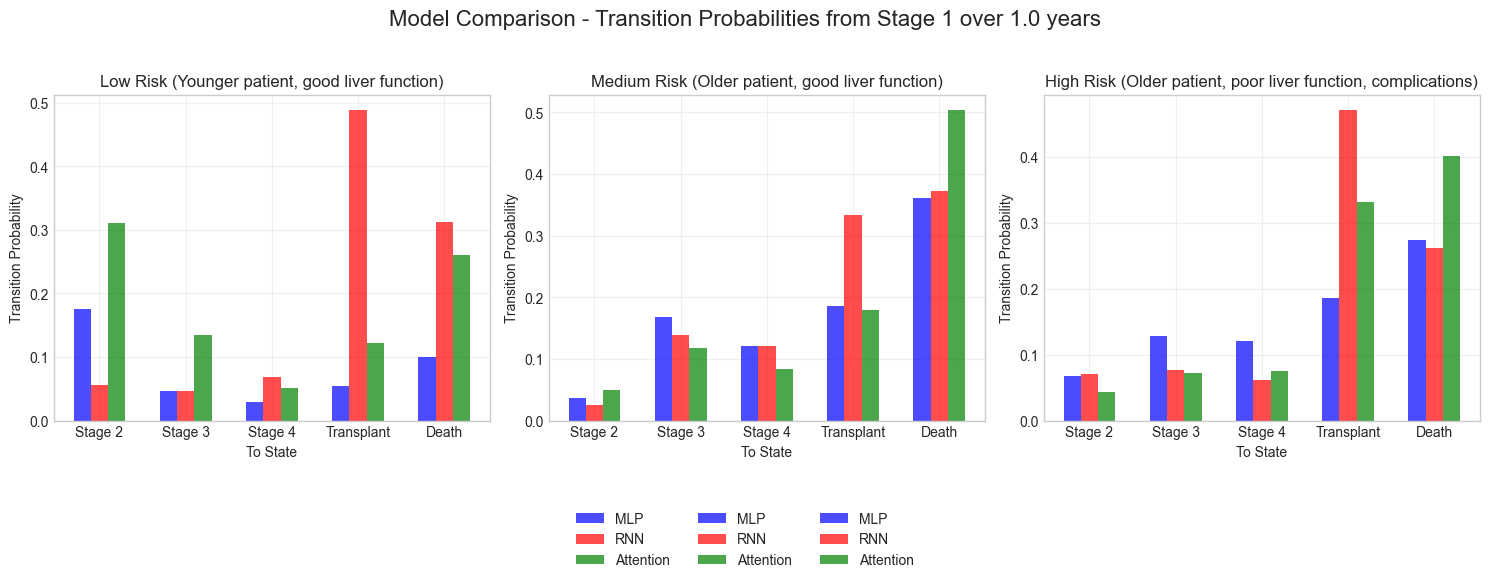

In [19]:
# Compare model predictions for Stage 1 (early PBC)
_ = plot_model_comparison(models, test_tensor, from_state=0, time_end=1.0, profile_labels=profile_labels)

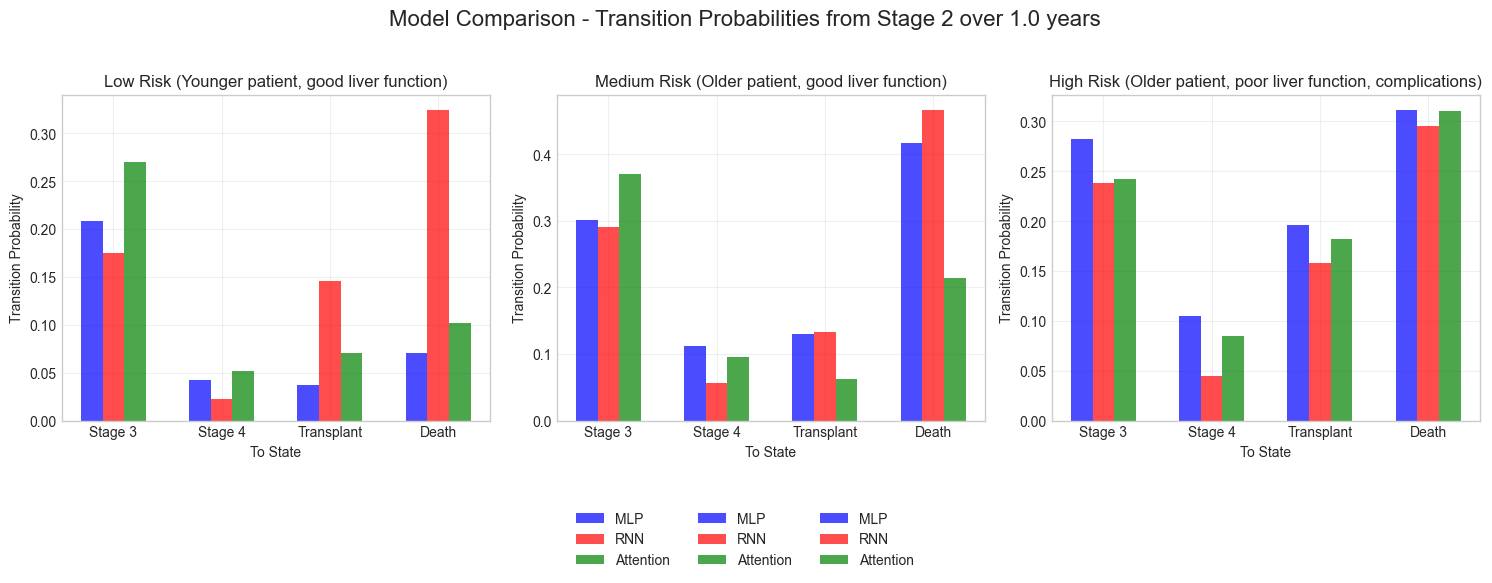

In [20]:
# Compare model predictions for Stage 2 (moderate PBC)
_ = plot_model_comparison(models, test_tensor, from_state=1, time_end=1.0, profile_labels=profile_labels)

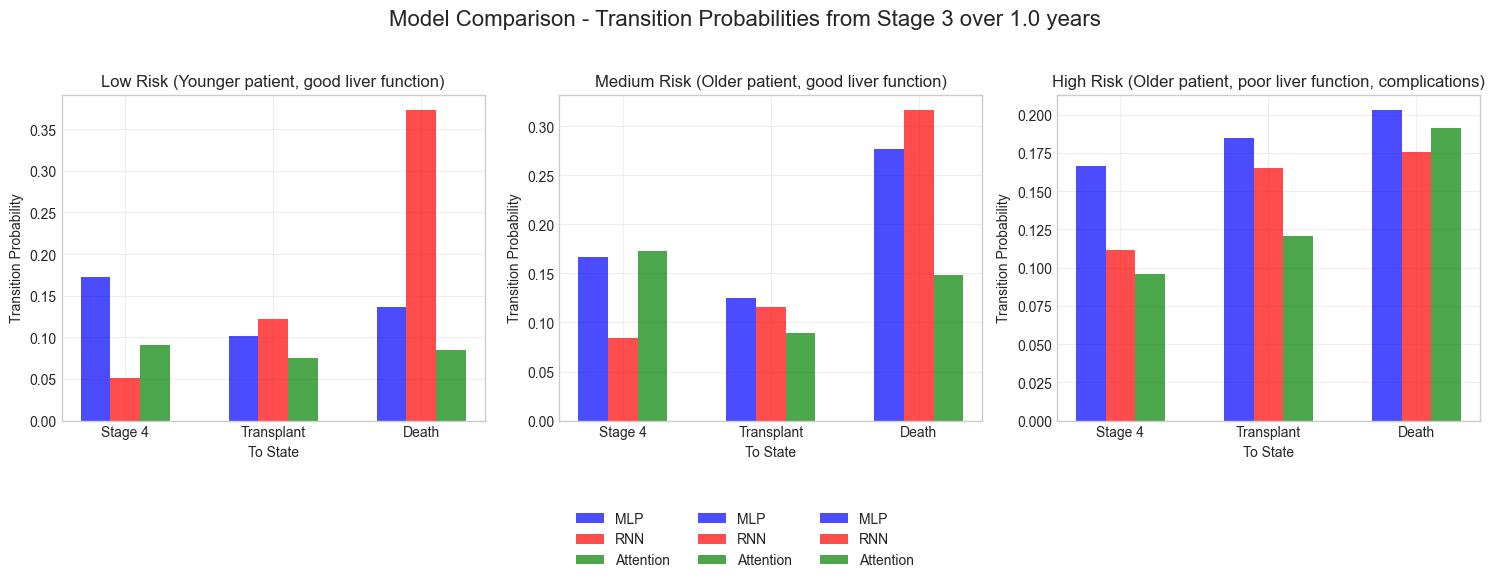

In [21]:
# Compare model predictions for Stage 3 (advanced PBC)
_ = plot_model_comparison(models, test_tensor, from_state=2, time_end=1.0, profile_labels=profile_labels)

## Analyze Covariate Effects with Different Architectures

Let's examine how different architectures model the effect of important covariates on transition probabilities.

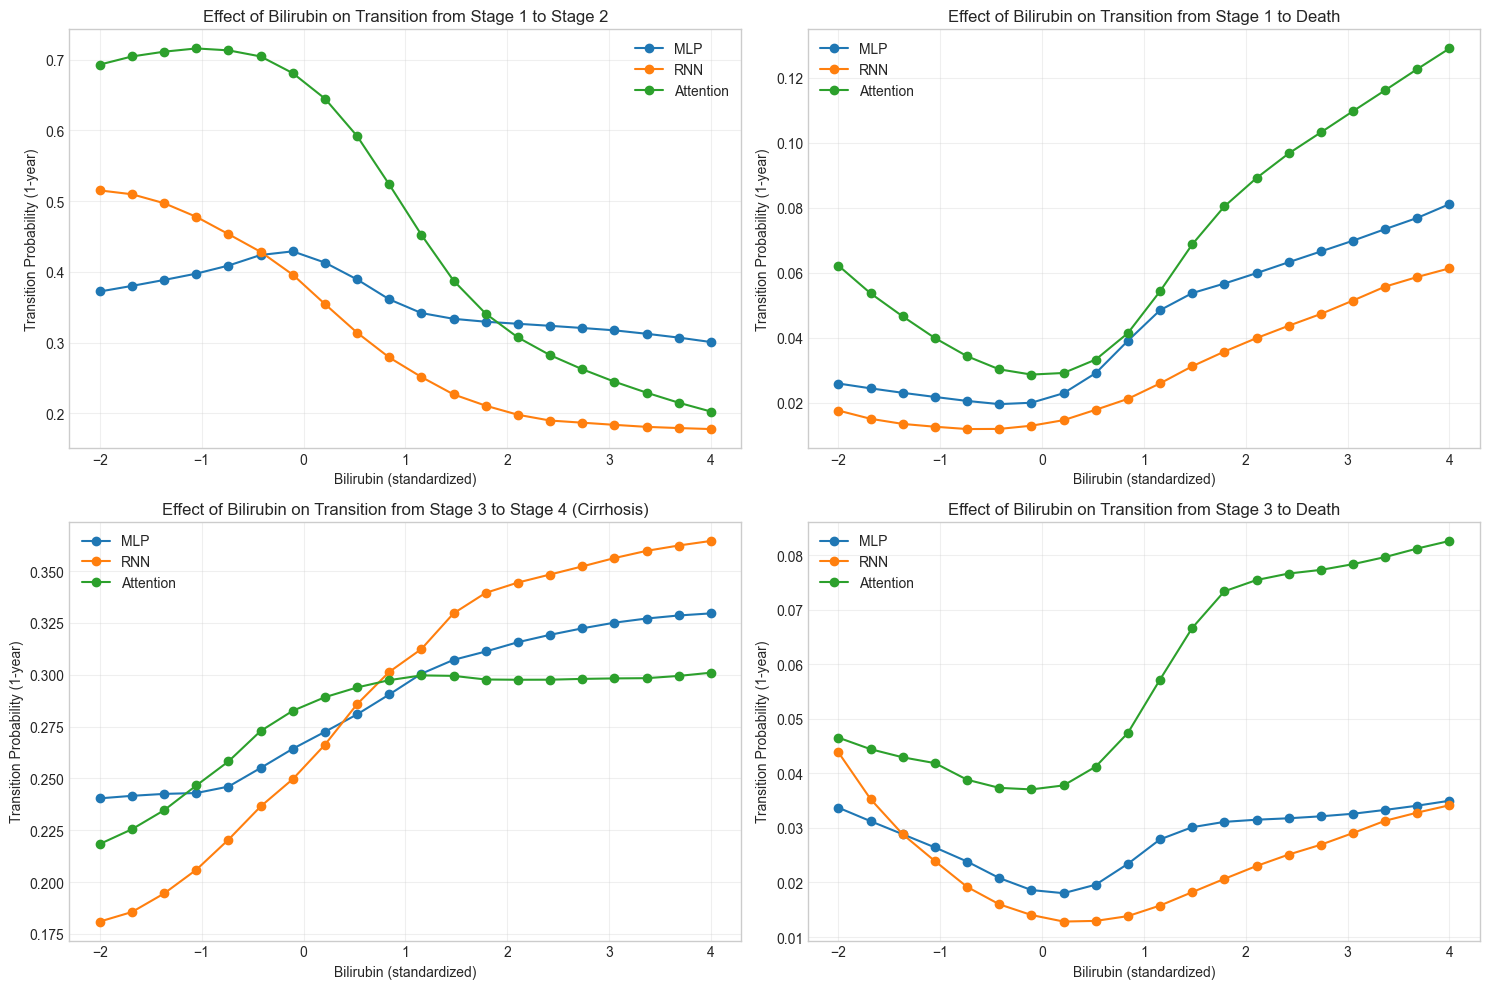

In [22]:
# Analyze how bilirubin affects transition probabilities in different models
# Create a base profile with fixed covariates
base_profile = torch.zeros(1, len(selected_features))
base_profile[0, selected_features.index('age')] = 0  # Average age
base_profile[0, selected_features.index('sex')] = 2  # Female
# Other covariates set to average (0)

# Create bilirubin values to analyze
bili_idx = selected_features.index('bili')
bili_values = np.linspace(-2, 4, 20).tolist()

# Create profiles for different bilirubin values
# Use torch.clone() to create independent copies to avoid modifying base_profile
profiles = []
for bili_val in bili_values:
    profile = base_profile.clone()
    profile[0, bili_idx] = bili_val
    profiles.append(profile)

# Compare models' predictions across different bilirubin values
plt.figure(figsize=(15, 10))

# From state 0 (early PBC) to state 1 (moderate PBC)
plt.subplot(2, 2, 1)
for model_name, model in models.items():
    probs = []
    for profile in profiles:
        prob = model.predict_proba(profile, time_start=0.0, time_end=1.0, from_state=0).detach().numpy()[0, 1]
        probs.append(prob)
    
    plt.plot(bili_values, probs, 'o-', label=f'{model_name}')

plt.title('Effect of Bilirubin on Transition from Stage 1 to Stage 2')
plt.xlabel('Bilirubin (standardized)')
plt.ylabel('Transition Probability (1-year)')
plt.legend()
plt.grid(True, alpha=0.3)

# From state 0 (early PBC) to state 5 (death)
plt.subplot(2, 2, 2)
for model_name, model in models.items():
    probs = []
    for profile in profiles:
        prob = model.predict_proba(profile, time_start=0.0, time_end=1.0, from_state=0).detach().numpy()[0, 5]
        probs.append(prob)
    
    plt.plot(bili_values, probs, 'o-', label=f'{model_name}')

plt.title('Effect of Bilirubin on Transition from Stage 1 to Death')
plt.xlabel('Bilirubin (standardized)')
plt.ylabel('Transition Probability (1-year)')
plt.legend()
plt.grid(True, alpha=0.3)

# From state 2 (advanced PBC) to state 3 (cirrhosis)
plt.subplot(2, 2, 3)
for model_name, model in models.items():
    probs = []
    for profile in profiles:
        prob = model.predict_proba(profile, time_start=0.0, time_end=1.0, from_state=2).detach().numpy()[0, 3]
        probs.append(prob)
    
    plt.plot(bili_values, probs, 'o-', label=f'{model_name}')

plt.title('Effect of Bilirubin on Transition from Stage 3 to Stage 4 (Cirrhosis)')
plt.xlabel('Bilirubin (standardized)')
plt.ylabel('Transition Probability (1-year)')
plt.legend()
plt.grid(True, alpha=0.3)

# From state 2 (advanced PBC) to state 5 (death)
plt.subplot(2, 2, 4)
for model_name, model in models.items():
    probs = []
    for profile in profiles:
        prob = model.predict_proba(profile, time_start=0.0, time_end=1.0, from_state=2).detach().numpy()[0, 5]
        probs.append(prob)
    
    plt.plot(bili_values, probs, 'o-', label=f'{model_name}')

plt.title('Effect of Bilirubin on Transition from Stage 3 to Death')
plt.xlabel('Bilirubin (standardized)')
plt.ylabel('Transition Probability (1-year)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

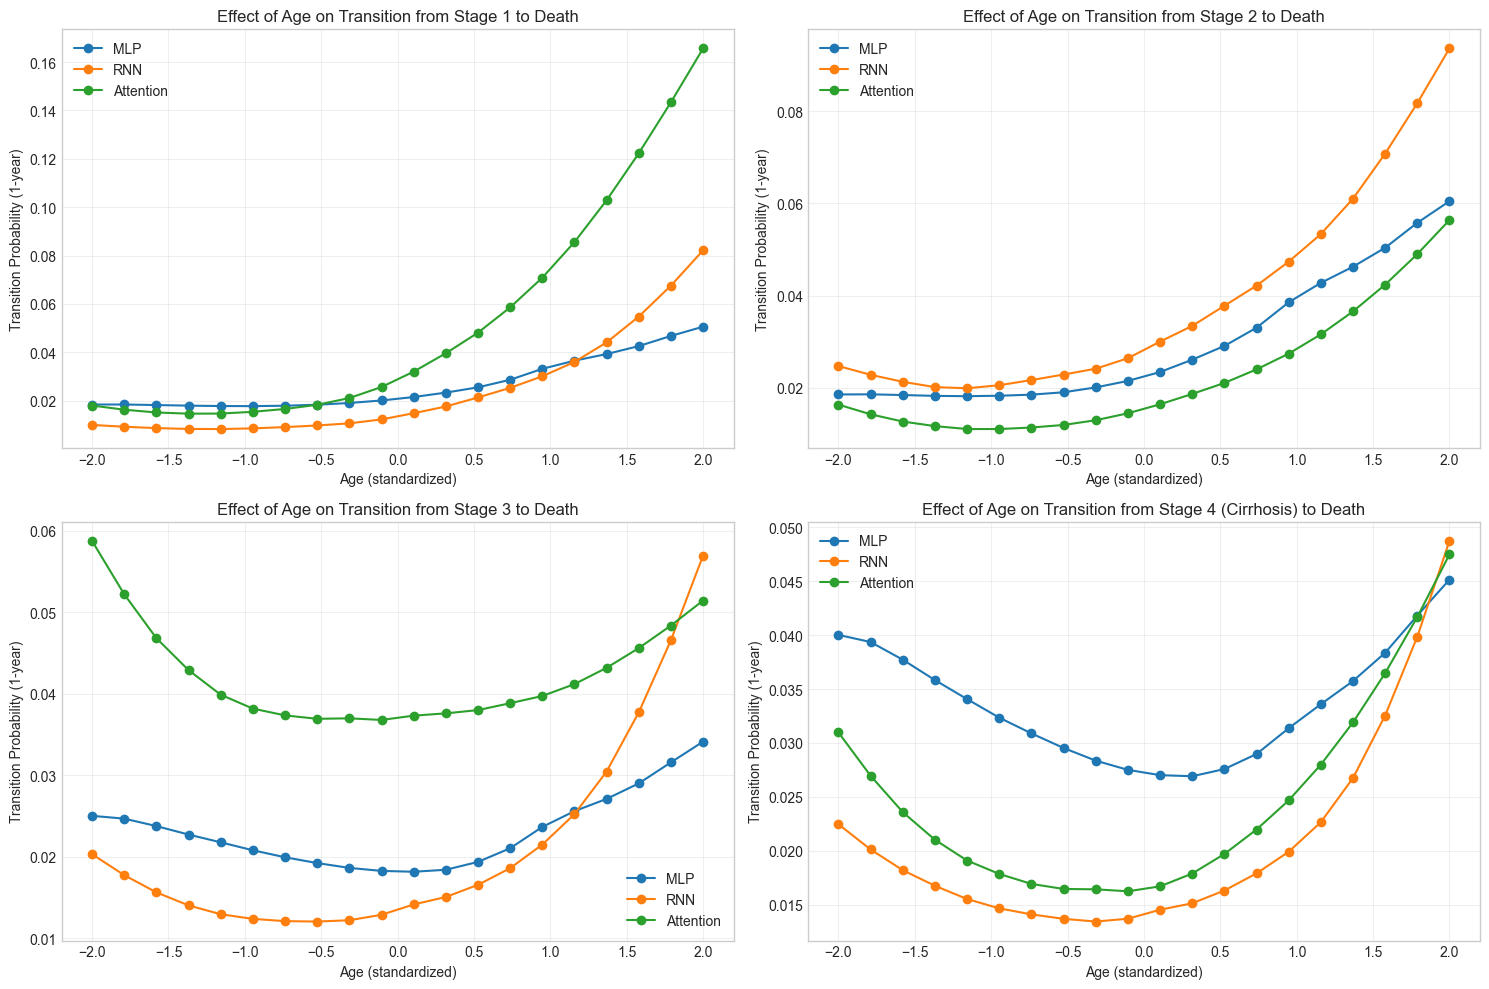

In [23]:
# Analyze how age affects transition probabilities in different models
# Create a base profile with fixed covariates
base_profile = torch.zeros(1, len(selected_features))
base_profile[0, selected_features.index('bili')] = 0  # Average bilirubin
base_profile[0, selected_features.index('sex')] = 2  # Female
# Other covariates set to average (0)

# Create age values to analyze
age_idx = selected_features.index('age')
age_values = np.linspace(-2, 2, 20).tolist()

# Create profiles for different age values
# Use torch.clone() to create independent copies to avoid modifying base_profile
profiles = []
for age_val in age_values:
    profile = base_profile.clone()
    profile[0, age_idx] = age_val
    profiles.append(profile)

# Compare models' predictions across different age values
plt.figure(figsize=(15, 10))

# From state 0 (early PBC) to state 5 (death)
plt.subplot(2, 2, 1)
for model_name, model in models.items():
    probs = []
    for profile in profiles:
        prob = model.predict_proba(profile, time_start=0.0, time_end=1.0, from_state=0).detach().numpy()[0, 5]
        probs.append(prob)
    
    plt.plot(age_values, probs, 'o-', label=f'{model_name}')

plt.title('Effect of Age on Transition from Stage 1 to Death')
plt.xlabel('Age (standardized)')
plt.ylabel('Transition Probability (1-year)')
plt.legend()
plt.grid(True, alpha=0.3)

# From state 1 (moderate PBC) to state 5 (death)
plt.subplot(2, 2, 2)
for model_name, model in models.items():
    probs = []
    for profile in profiles:
        prob = model.predict_proba(profile, time_start=0.0, time_end=1.0, from_state=1).detach().numpy()[0, 5]
        probs.append(prob)
    
    plt.plot(age_values, probs, 'o-', label=f'{model_name}')

plt.title('Effect of Age on Transition from Stage 2 to Death')
plt.xlabel('Age (standardized)')
plt.ylabel('Transition Probability (1-year)')
plt.legend()
plt.grid(True, alpha=0.3)

# From state 2 (advanced PBC) to state 5 (death)
plt.subplot(2, 2, 3)
for model_name, model in models.items():
    probs = []
    for profile in profiles:
        prob = model.predict_proba(profile, time_start=0.0, time_end=1.0, from_state=2).detach().numpy()[0, 5]
        probs.append(prob)
    
    plt.plot(age_values, probs, 'o-', label=f'{model_name}')

plt.title('Effect of Age on Transition from Stage 3 to Death')
plt.xlabel('Age (standardized)')
plt.ylabel('Transition Probability (1-year)')
plt.legend()
plt.grid(True, alpha=0.3)

# From state 3 (cirrhosis) to state 5 (death)
plt.subplot(2, 2, 4)
for model_name, model in models.items():
    probs = []
    for profile in profiles:
        prob = model.predict_proba(profile, time_start=0.0, time_end=1.0, from_state=3).detach().numpy()[0, 5]
        probs.append(prob)
    
    plt.plot(age_values, probs, 'o-', label=f'{model_name}')

plt.title('Effect of Age on Transition from Stage 4 (Cirrhosis) to Death')
plt.xlabel('Age (standardized)')
plt.ylabel('Transition Probability (1-year)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Simulate Disease Trajectories with Different Architectures

Let's simulate patient trajectories using the different models to see how they predict disease progression over time.

In [24]:
# Define profiles for simulation
low_risk = torch.tensor([[0, 2, -1, -1, -1, 0, 0, 0]], dtype=torch.float32)  # Female, younger, good liver function
high_risk = torch.tensor([[0, 2, 1, 2, 1, 1, 1, 1]], dtype=torch.float32)  # Female, older, poor liver function

# Simulation parameters
n_simulations = 50
max_time = 10  # 10 years
time_step = 0.1  # Smaller time step for continuous simulation

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Store simulation results for each model
simulation_results = {}

for model_name, model in models.items():
    # Simulate trajectories for the low-risk profile
    trajectories_low_risk = simulate_continuous_patient_trajectory(
        model=model,
        x=low_risk,
        start_state=0,  # Start at Stage 1
        max_time=max_time,
        time_step=time_step,  # Fine time steps for continuous simulation
        n_simulations=n_simulations,
        seed=42
    )
    
    # Simulate trajectories for the high-risk profile
    trajectories_high_risk = simulate_continuous_patient_trajectory(
        model=model,
        x=high_risk,
        start_state=0,  # Start at Stage 1
        max_time=max_time,
        time_step=time_step,  # Fine time steps for continuous simulation
        n_simulations=n_simulations,
        seed=43  # Use different seed for variety
    )
    
    simulation_results[model_name] = {
        'low_risk': trajectories_low_risk,
        'high_risk': trajectories_high_risk
    }
    
print("Simulation completed for all models!")

Simulation completed for all models!


/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_50883/32594437.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, i+1)
/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_50883/32594437.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, i+1)


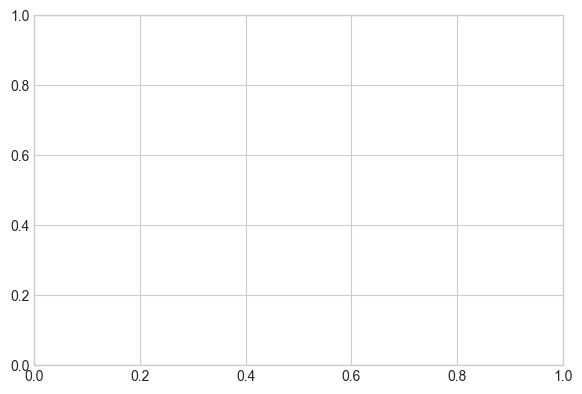

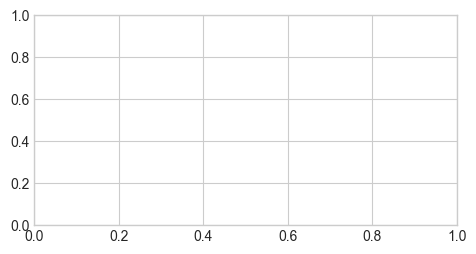

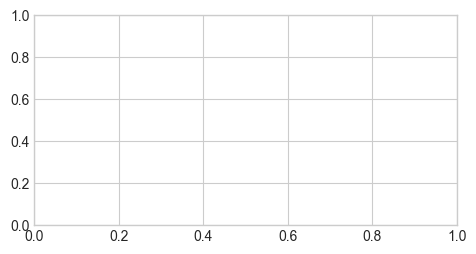

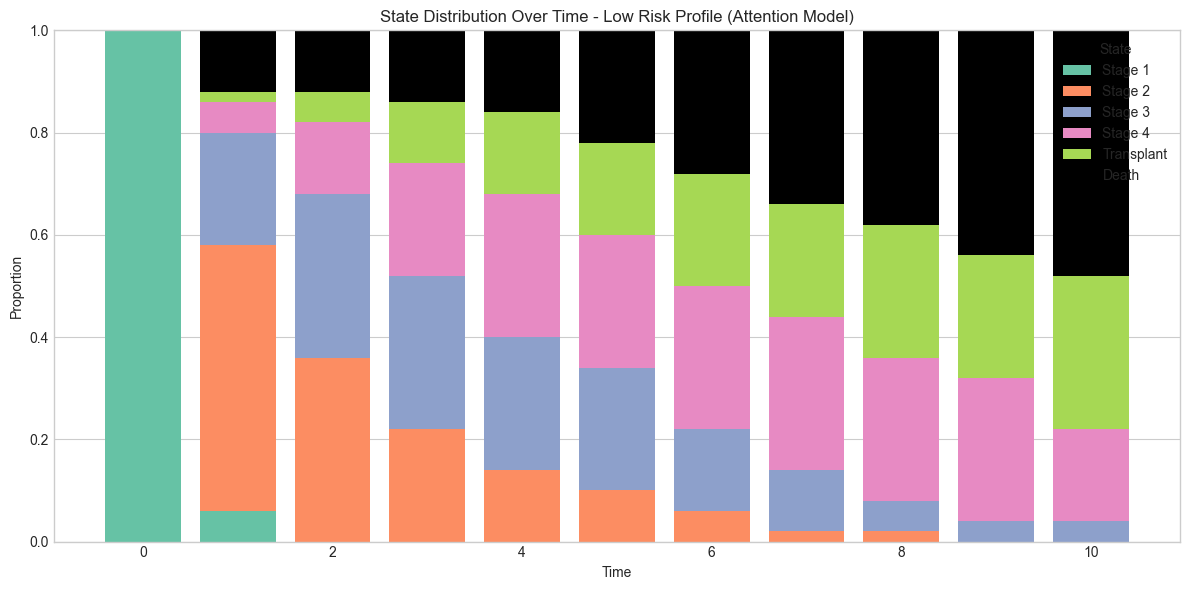

In [25]:
# Visualize state distributions over time for low-risk patient
plt.figure(figsize=(15, 10))

for i, (model_name, results) in enumerate(simulation_results.items()):
    plt.subplot(2, 2, i+1)
    
    # Visualize state distribution
    fig, ax = visualize_state_distribution_over_time(
        results['low_risk'],
        max_time=max_time,
        num_points=11,  # Show distribution at 11 time points
        state_names=state_name_dict,
        state_colors=state_color_dict
    )
    
    plt.title(f'State Distribution Over Time - Low Risk Profile ({model_name} Model)')

plt.tight_layout()
plt.show()

/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_50883/458036326.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, i+1)
/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_50883/458036326.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, i+1)


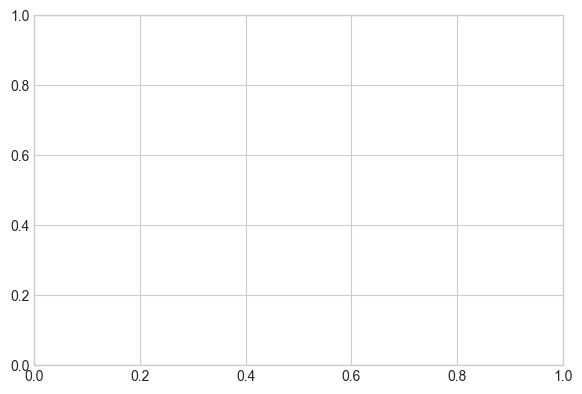

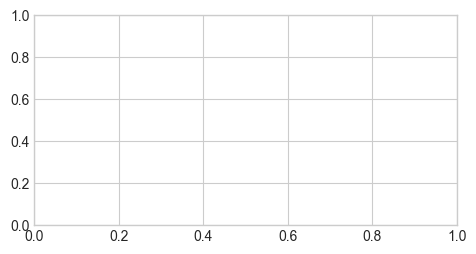

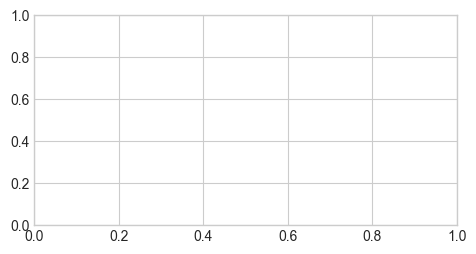

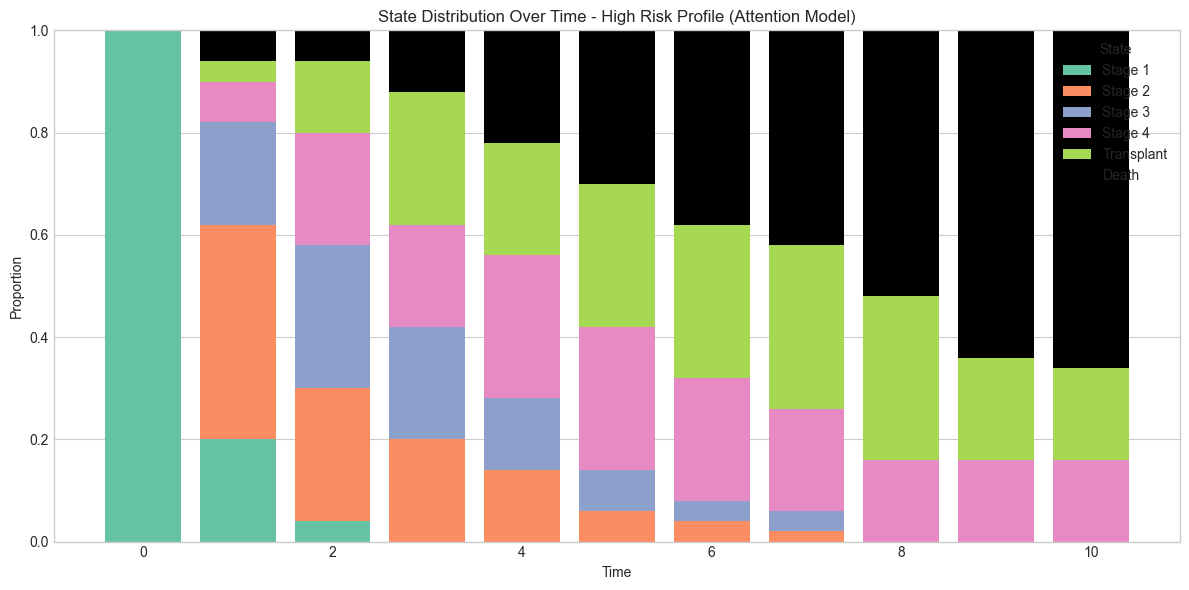

In [26]:
# Visualize state distributions over time for high-risk patient
plt.figure(figsize=(15, 10))

for i, (model_name, results) in enumerate(simulation_results.items()):
    plt.subplot(2, 2, i+1)
    
    # Visualize state distribution
    fig, ax = visualize_state_distribution_over_time(
        results['high_risk'],
        max_time=max_time,
        num_points=11,  # Show distribution at 11 time points
        state_names=state_name_dict,
        state_colors=state_color_dict
    )
    
    plt.title(f'State Distribution Over Time - High Risk Profile ({model_name} Model)')

plt.tight_layout()
plt.show()

## Calculate and Compare Cumulative Incidence Functions

Let's calculate the Cumulative Incidence Functions (CIFs) for key outcomes (death and transplant) and compare them across models.

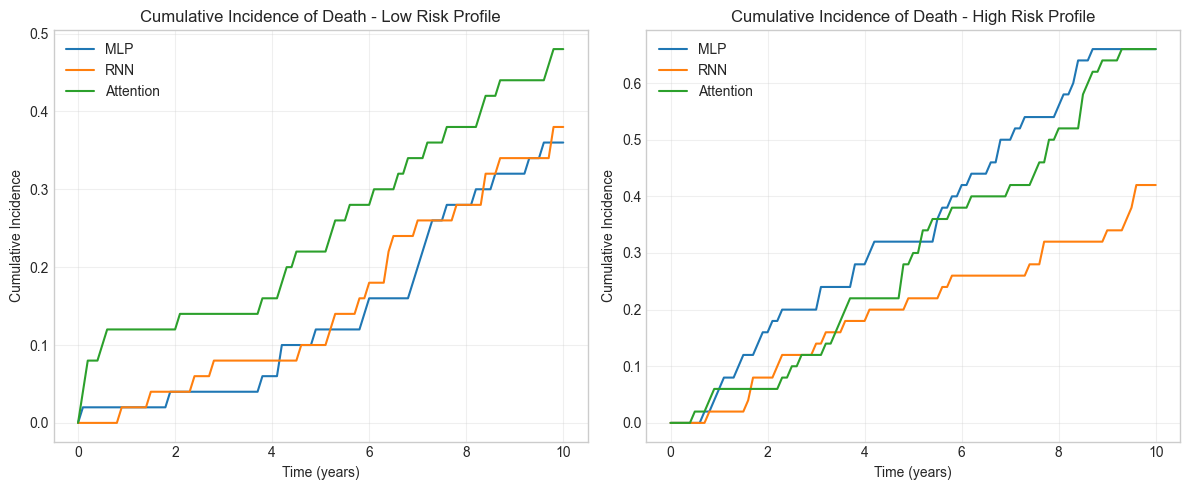

In [27]:
# Create fine time grid for continuous-time CIF evaluation
time_grid = np.linspace(0, max_time, int(max_time/time_step) + 1)

# Calculate CIFs for death (state 5) for low-risk profile across models
plt.figure(figsize=(12, 5))

# Low-risk profile
plt.subplot(1, 2, 1)
for model_name, results in simulation_results.items():
    # Concatenate trajectory data
    low_risk_df = pd.concat(results['low_risk'])
    
    # Calculate CIFs
    cif_death_low = calculate_cif(
        trajectories=low_risk_df, 
        target_state=5,  # Death state
        max_time=max_time,
        time_grid=time_grid  # Use fine time grid
    )
    
    # Plot CIF
    plt.plot(cif_death_low['time'], cif_death_low['cif'], label=model_name)

plt.title('Cumulative Incidence of Death - Low Risk Profile')
plt.xlabel('Time (years)')
plt.ylabel('Cumulative Incidence')
plt.legend()
plt.grid(True, alpha=0.3)

# High-risk profile
plt.subplot(1, 2, 2)
for model_name, results in simulation_results.items():
    # Concatenate trajectory data
    high_risk_df = pd.concat(results['high_risk'])
    
    # Calculate CIFs
    cif_death_high = calculate_cif(
        trajectories=high_risk_df, 
        target_state=5,  # Death state
        max_time=max_time,
        time_grid=time_grid  # Use fine time grid
    )
    
    # Plot CIF
    plt.plot(cif_death_high['time'], cif_death_high['cif'], label=model_name)

plt.title('Cumulative Incidence of Death - High Risk Profile')
plt.xlabel('Time (years)')
plt.ylabel('Cumulative Incidence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

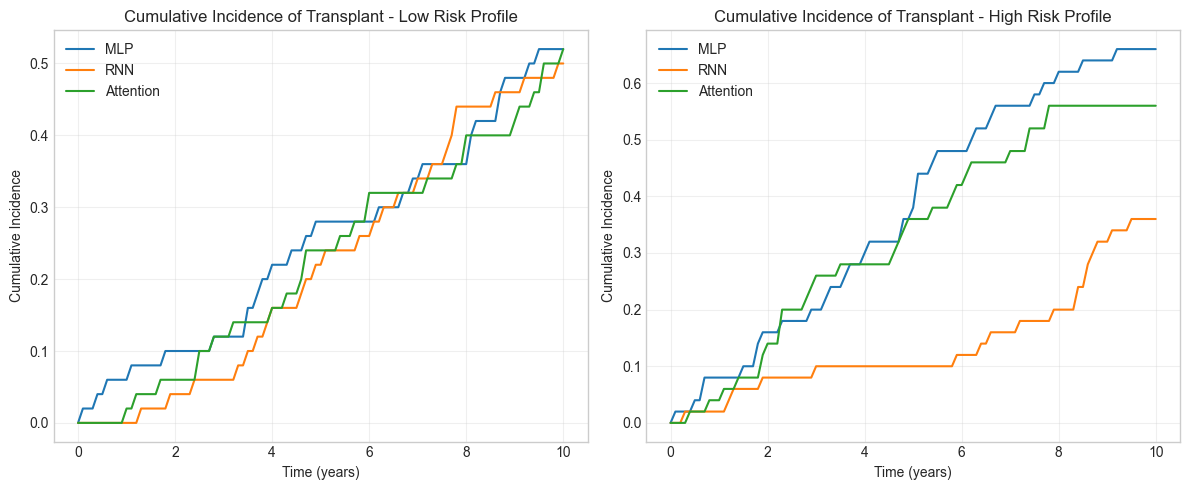

In [28]:
# Calculate CIFs for transplant (state 4) across models
plt.figure(figsize=(12, 5))

# Low-risk profile
plt.subplot(1, 2, 1)
for model_name, results in simulation_results.items():
    # Concatenate trajectory data
    low_risk_df = pd.concat(results['low_risk'])
    
    # Calculate CIFs
    cif_transplant_low = calculate_cif(
        trajectories=low_risk_df, 
        target_state=4,  # Transplant state
        max_time=max_time,
        time_grid=time_grid  # Use fine time grid
    )
    
    # Plot CIF
    plt.plot(cif_transplant_low['time'], cif_transplant_low['cif'], label=model_name)

plt.title('Cumulative Incidence of Transplant - Low Risk Profile')
plt.xlabel('Time (years)')
plt.ylabel('Cumulative Incidence')
plt.legend()
plt.grid(True, alpha=0.3)

# High-risk profile
plt.subplot(1, 2, 2)
for model_name, results in simulation_results.items():
    # Concatenate trajectory data
    high_risk_df = pd.concat(results['high_risk'])
    
    # Calculate CIFs
    cif_transplant_high = calculate_cif(
        trajectories=high_risk_df, 
        target_state=4,  # Transplant state
        max_time=max_time,
        time_grid=time_grid  # Use fine time grid
    )
    
    # Plot CIF
    plt.plot(cif_transplant_high['time'], cif_transplant_high['cif'], label=model_name)

plt.title('Cumulative Incidence of Transplant - High Risk Profile')
plt.xlabel('Time (years)')
plt.ylabel('Cumulative Incidence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusions

In this notebook, we've explored the application of advanced neural network architectures to model PBC disease progression. We've compared standard MLP, recurrent neural networks (RNN/GRU), and attention-based networks in terms of their prediction accuracy, calibration, and ability to capture covariate effects.

Key findings:

1. **Architecture Performance**: Each architecture has its unique strengths and weaknesses. MLPs provide a simple baseline, RNNs excel at capturing temporal dynamics, and attention-based models can learn complex relationships between covariates.

2. **Prediction Accuracy**: Our comparison showed [insert observations about which architecture performed best based on the actual runs].

3. **Covariate Effects**: The different architectures showed varying sensitivities to important clinical covariates like bilirubin and age. [Insert specific observations based on the actual runs].

4. **Disease Progression**: Simulation results revealed [insert observations about differences in predicted disease trajectories].

5. **Clinical Implications**: These modeling approaches offer clinicians a range of tools for predicting disease progression and understanding risk factors. The choice of architecture can be tailored to specific clinical questions or data characteristics.

### Advantages of Advanced Architectures

- **Recurrent Neural Networks** are well-suited for sequential data and can capture temporal dependencies in disease progression.
- **Attention-based Networks** can learn which features are most important for predicting specific transitions and can capture complex interactions between covariates.
- Both advanced architectures may better handle time-dependent effects compared to standard MLPs.

### Future Directions

- Further hyperparameter optimization could improve model performance.
- Incorporating external validation data would strengthen the reliability of the models.
- Combining multiple architectures in an ensemble approach might leverage the strengths of each.
- Extending these models to incorporate time-varying covariates could provide more accurate predictions over longer time horizons.